In [55]:
from bs4 import BeautifulSoup
import requests
import json

header = {
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36'
}

sid = {'정치':100,
       '경제':101,
       '사회':102,
       '생활/문화':103,
       'IT/과학':105,
       '세계':104
}

result = {}

def decode_text(body):
    try:
        cleaned_eval = eval(f'"{body}"')
    except Exception as e:
        pass

    # str.encode()와 decode()를 사용하여 처리
    try:
        cleaned_encode = body.encode('utf-8').decode('unicode_escape')
    except Exception as e:
        pass

    # replace()로 역슬래시 제거
    cleaned_replace = body.replace("\\", "")
    return cleaned_replace

def fetch_link_list(sid):
    '''뉴스 카테고리 5페이지의 URL 목록 return'''
    cursor = 0
    link_list = []
    for _ in range(5):
        URL = f'https://news.naver.com/section/template/SECTION_ARTICLE_LIST?sid={sid}&next={cursor}'
        
        response = requests.get(URL, headers=header)
        datas = response.json()
        text = datas['renderedComponent']['SECTION_ARTICLE_LIST']
        soup = BeautifulSoup(text,'html.parser')

        # '더보기' 헤드에 있는 뉴스로 cursor 변경
        cursor = soup.select_one('div._PERSIST_META')['data-cursor']

        # cursor가 가리키는 뉴스로부터 1페이지 분량 URL 추출
        links = soup.select('a.sa_thumb_link')
        link_list += [link.attrs['href'] for link in links]

    return link_list

def fetch_summary_data(article_url):
    '''뉴스의 AI 요약봇의 제목, 본문을 dictionary형으로 return'''
    parts = article_url.split('/')
    extracted_part = f'{parts[5]}/{parts[6]}'
    extracted_part
    URL = f'https://tts.news.naver.com/article/{extracted_part}/summary?callback=callback&JSON'

    response = requests.get(URL, headers=header)
    fetchs = BeautifulSoup(response.text, 'html.parser')
    json_string = response.text.replace("/**/callback(","")[:-2]
    summary_bot = json.loads(json_string)

    news_data = {
    '제목' : summary_bot["title"],
    'AI 요약': summary_bot["summary"].replace("<br/><br/>","")
}
    return news_data

# sid 딕셔너리의 각 항목에 대해 반복
for k, v in sid.items():
    sid_result = [fetch_summary_data(article_url) for article_url in fetch_link_list(v)]
    result[k] = sid_result # result 딕셔너리에 키 카테고리 항목과 값을 sid_result로 추가

# 수집한 데이터를 JSON 파일(news_crawl_bs.json)로 저장
with open('summary_crawl_bs.json', 'w', encoding='utf-8') as file:
    json.dump(result, file, indent=4, ensure_ascii=False)

C:\Users\every\AppData\Local\Temp\ipykernel_18764\1332921144.py:64: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  fetchs = BeautifulSoup(response.text, 'html.parser')


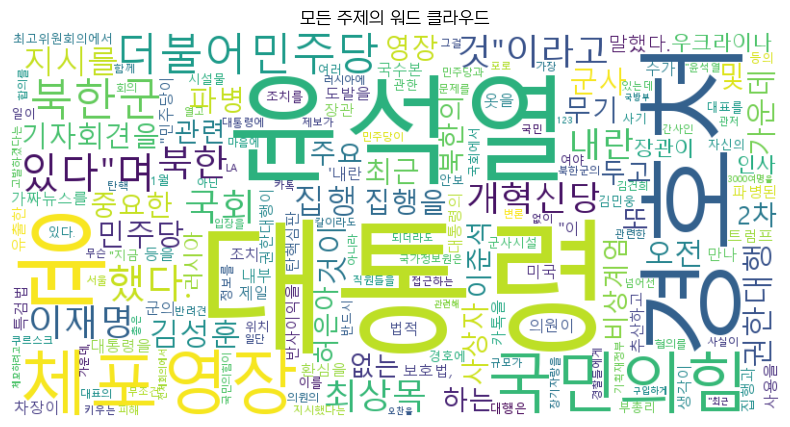

In [116]:
import json
import re
from gensim import corpora
from gensim.models import LdaModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 설정 (전역)
plt.rc('font', family='NEXON Lv1 Gothic OTF')
# 마이너스 폰트 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False



# 불용어 리스트 정의
stop_words = [
    '은', '는', '이', '가', '의', '에', '에서', '과', '와', '도', '로',
    '아', '야', '한', '한테', '에게', '나', '너', '그', '그녀', '이',
    '저', '우리', '그들', '당신', '이들', '그', '저', '이것', '저것',
    '이런', '그런', '아무', '모든', '어떤', '누구', '어느', '왜',
    '어떻게', '무엇', '뭐', '그러다', '하다', '있다', '없다', '되다',
    '가다', '오다', '보다', '주다',
    '오늘', '내일', '어제', '지금', '언제', '시간', '년', '월', '일',
    '그리고', '하지만', '또는', '그럼', '그래서', '즉', '그러나', '또한', '뿐만 아니라', '이외에도',
    '윤건영', '전', '허', '있는', '수', '대표가', '대표는', '최', '김', '게', '안', '의원은', '좀', '것으로',
    '있다고', '것', '대한', '저는', '있다고', '이제', '를', '것으로', '등', '당', '지난', '통해',
    '이날','한다"고','있다','할','위해','했다','했다고','겸','했는지','이렇게','놓고','하고','것은','있을','다른',
    '이게','있고','될','대해','했다','있다"고','찾아','같은','측은','하고','놓고','것을','향해','대해','년','월',
    '1일', '2일', '3일', '4일', '5일', '6일', '7일', '8일', '9일', '10일',
    '11일', '12일', '13일', '14일', '15일', '16일', '17일', '18일', '19일', '20일',
    '21일', '22일', '23일', '24일', '25일', '26일', '27일', '28일', '29일', '30일', '31일', '대통령이'
]

    
# JSON 파일 로드
with open('summary_crawl_bs.json', 'r', encoding='utf-8') as json_file:
    articles = json.load(json_file)
# 문서 전처리
texts = []
for article in articles['정치']:
    # 내용에서 불용어 제거 및 토큰화
    tokens = article['AI 요약'].split()
    tokens = [word for word in tokens if word not in stop_words]
    texts.append(tokens)

# 단어 사전 생성
dictionary = corpora.Dictionary(texts)

# 문서-단어 행렬 생성
corpus = [dictionary.doc2bow(text) for text in texts]

# LDA 모델 학습
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# 모든 주제의 워드 클라우드를 하나의 이미지로 합치기
combined_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    font_path='C:/Windows/Fonts/malgun.ttf'  # Malgun Gothic 폰트 경로
)

# 각 주제의 단어 빈도를 합산
combined_frequencies = {}

for i in range(lda_model.num_topics):
    word_dict = dict(lda_model.show_topic(i, topn=50))  # 각 주제의 상위 50개 단어
    for word, freq in word_dict.items():
        if word in combined_frequencies:
            combined_frequencies[word] += freq
        else:
            combined_frequencies[word] = freq

# 합쳐진 단어 빈도로 워드 클라우드 생성
combined_wordcloud.generate_from_frequencies(combined_frequencies)

# 워드 클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(combined_wordcloud, interpolation='bilinear')
plt.axis('off')  # 축 표시 제거
plt.title('모든 주제의 워드 클라우드')
plt.show()


In [101]:
perplexity = lda_model.log_perplexity(corpus)
print(f"Perplexity: {perplexity}")
from gensim.models import CoherenceModel

# Coherence score 계산
coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")


Perplexity: -8.566143981894877
Coherence Score: 0.38955492316188767
